<a id="1"></a> <br>
# Step 1: Load and Explore the Data
First, we import necessary libraries and load the datasets:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [2]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<a id="2"></a> <br>
# Step 2: Visualizations 
## 1. Distribution of Sale Prices
> Understanding how the sale prices are distributed can help identify skewness and outliers.

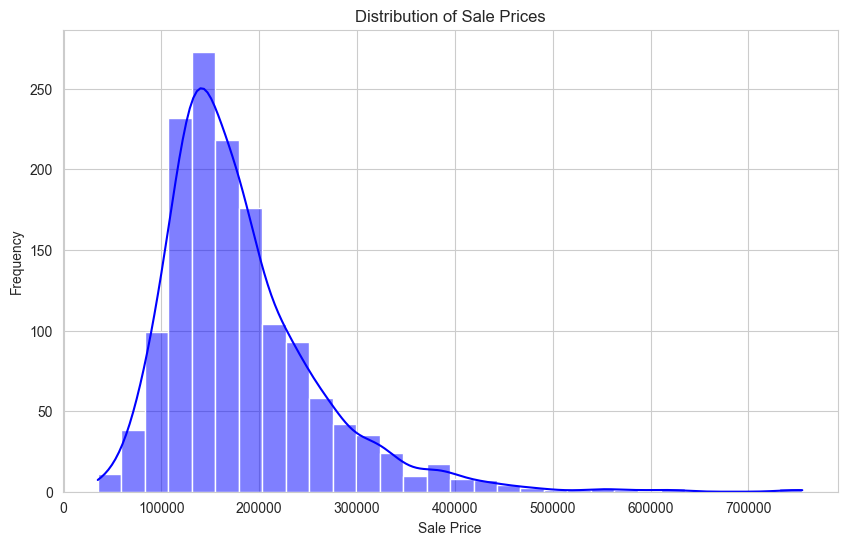

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of Sale Prices
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()


## 2. Correlation Heatmap
> A heatmap of correlations between numerical features and the sale price to identify which variables are most related to the price.

## 3. Boxplot of Sale Prices by Overall Quality
> This can show the relationship between the overall quality of a house and its sale price.

<a id="3"></a> <br>
# Step 3: Preprocess the Data
> Handle missing values, encode categorical variables, and scale numerical features:

In [5]:
# Separate target variable and predictors
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = np.log(train_df['SalePrice'])  # Transform target variable with logarithm
X_test = test_df.drop(['Id'], axis=1)

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])


In [6]:
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.2,random_state=32)

<a id="4"></a> <br>
# Step 4: Define the Model and Bundle Preprocessing and Modeling Code in a Pipeline

> We use a RandomForestRegressor for this task:

In [7]:
rf_model = RandomForestRegressor()
xgb_model=XGBRegressor()
la_model=Lasso(alpha=0.01)
svm_model=SVR()

In [8]:
# Create the voting regressor with the individual models
voting_model = VotingRegressor([('rf', rf_model), ('gb', xgb_model), ('linear', la_model)])

> This simplifies fitting and predictions:

In [9]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', voting_model)])

# Train the model
my_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrL...
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...)),
                                             ('linear', Lasso(alpha=0.01))]))])

In [10]:
y_pred=my_pipeline.predict(X_cv)
print(mean_squared_error(y_cv,y_pred))
print(mean_squared_error(np.exp(y_cv),np.exp(y_pred)))


0.026203039641953554
1316967880.1318188


<a id="5"></a> <br>
# Step 5: Predict and Prepare Submission
> Predict using the test dataset and prepare the dataframe:

In [11]:
# Predictions in log scale
predictions_log_scale = my_pipeline.predict(X_test)

# Convert predictions back from log scale
predictions = np.exp(predictions_log_scale)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

predictions_df.head()

,Id,SalePrice
0,1461,126032.763899
1,1462,153409.710740
2,1463,173106.401551
3,1464,183493.740127
4,1465,185077.504655


In [12]:
predictions_df.info

<bound method DataFrame.info of         Id      SalePrice
0     1461  126032.763899
1     1462  153409.710740
2     1463  173106.401551
3     1464  183493.740127
4     1465  185077.504655
...    ...            ...
1454  2915   86820.614973
1455  2916   83036.212276
1456  2917  166877.560127
1457  2918  113075.357270
1458  2919  227401.057539

[1459 rows x 2 columns]>

In [13]:
predictions_df.to_csv("submission3.csv", index=False)
